<a href="https://colab.research.google.com/github/kylemcq13/Projects/blob/master/16_10_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Life Expectancy

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import math
import numpy as np
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from scipy import stats
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [0]:
#upload the dataset
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

# Data Cleaning

In [0]:
#preview the dataset

life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [0]:
#dataset info
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [0]:
#calculate the percentage of null values in each variable
life_df.isnull().sum()*100/life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [0]:
#unique values in each variable
life_df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
 BMI                                608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
 HIV/AIDS                           200
GDP                                2490
Population                         2278
 thinness  1-19 years               200
 thinness 5-9 years                 207
Income composition of resources     625
Schooling                           173
dtype: int64

In [0]:
#search for unique values

for column_name in life_df.columns:
    print("Unique values in column {} are: {}".format(column_name, life_df[column_name].unique()))

Unique values in column Country are: ['Afghanistan' 'Albania' 'Algeria' "Côte d'Ivoire" 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Slovakia'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 

It appears we do not have any problematic values. Since our dataset is a time series, lets interpolate the data then see where it stands.

In [0]:
#interpolate the data to take care of null values
life_df.interpolate(method ='linear', limit=None,inplace=True, limit_direction='both', limit_area=None, downcast=None)

In [0]:
life_df.isnull().sum()*100/life_df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

In [0]:
#there seem to be some trailing spaces in variable names, lets fix this

life_df.rename(columns={" BMI ":"BMI", "Life expectancy ":"Life_Expectancy", "Adult Mortality":"Adult_Mortality",
                   "infant deaths":"Infant_Deaths", "percentage expenditure":"Percentage_Expenditure","Hepatitis B":"Hepatitis_B",
                  "Measles ":"Measles"," BMI ":"BMI","under-five deaths ":"Under_Five_Deaths","Diphtheria ":"Diphtheria",
                  " HIV/AIDS":"HIV/AIDS"," thinness  1-19 years":"thinness_1to19_years"," thinness 5-9 years":"thinness_5to9_years","Income composition of resources":"Income_Comp_Of_Resources",
                   "Total expenditure":"Tot_Exp"},inplace=True)

In [0]:
life_df.describe()

,Year,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,82.474643,5.940955,82.246086,1.742103,7432.027910,1.229209e+07,4.882301,4.920439,0.634458,12.076804
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,23.420689,2.445751,23.705664,5.077785,13410.150286,5.471908e+07,4.433359,4.532488,0.209574,3.342316
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,78.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


From what we can see above, infant deaths, percentage expenditure, measles, GDP, and population seem to have the most extreme outliers. Let's take a closer look at these variables using Tukey's method Z and boxplots. There doesn't seem to be any "nonsense" values within the dataset so I don't think dropping anything is really necessary yet. 

In [0]:
#Use Tukey's method to determine the number of outliers in each variable

columns = ["BMI","Life_Expectancy", "Adult_Mortality","Infant_Deaths", "Percentage_Expenditure","Hepatitis_B",
           "Measles","Under_Five_Deaths","Diphtheria","HIV/AIDS","thinness_1to19_years","thinness_5to9_years","Income_Comp_Of_Resources",
            "Tot_Exp", "Alcohol", "Polio", "GDP", "Population", "Schooling"]

for var in columns:
    q75, q25 = np.percentile(life_df[var], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(var, len((np.where((life_df[var] > max_val) | (life_df[var] < min_val))[0]))))



Number of outliers in BMI: 0
Number of outliers in Life_Expectancy: 12
Number of outliers in Adult_Mortality: 82
Number of outliers in Infant_Deaths: 315
Number of outliers in Percentage_Expenditure: 389
Number of outliers in Hepatitis_B: 248
Number of outliers in Measles: 542
Number of outliers in Under_Five_Deaths: 394
Number of outliers in Diphtheria: 301
Number of outliers in HIV/AIDS: 542
Number of outliers in thinness_1to19_years: 89
Number of outliers in thinness_5to9_years: 97
Number of outliers in Income_Comp_Of_Resources: 130
Number of outliers in Tot_Exp: 35
Number of outliers in Alcohol: 1
Number of outliers in Polio: 282
Number of outliers in GDP: 349
Number of outliers in Population: 365
Number of outliers in Schooling: 53


We can see that many of these variables have a substantial amount of outliers. As previously stated, the following variables were suspect to have a high amount of outliers : infant deaths, percentage expenditure, measles, GDP, and population. Tukey's method confirms this. 

Let's get a visual of these using boxplots.

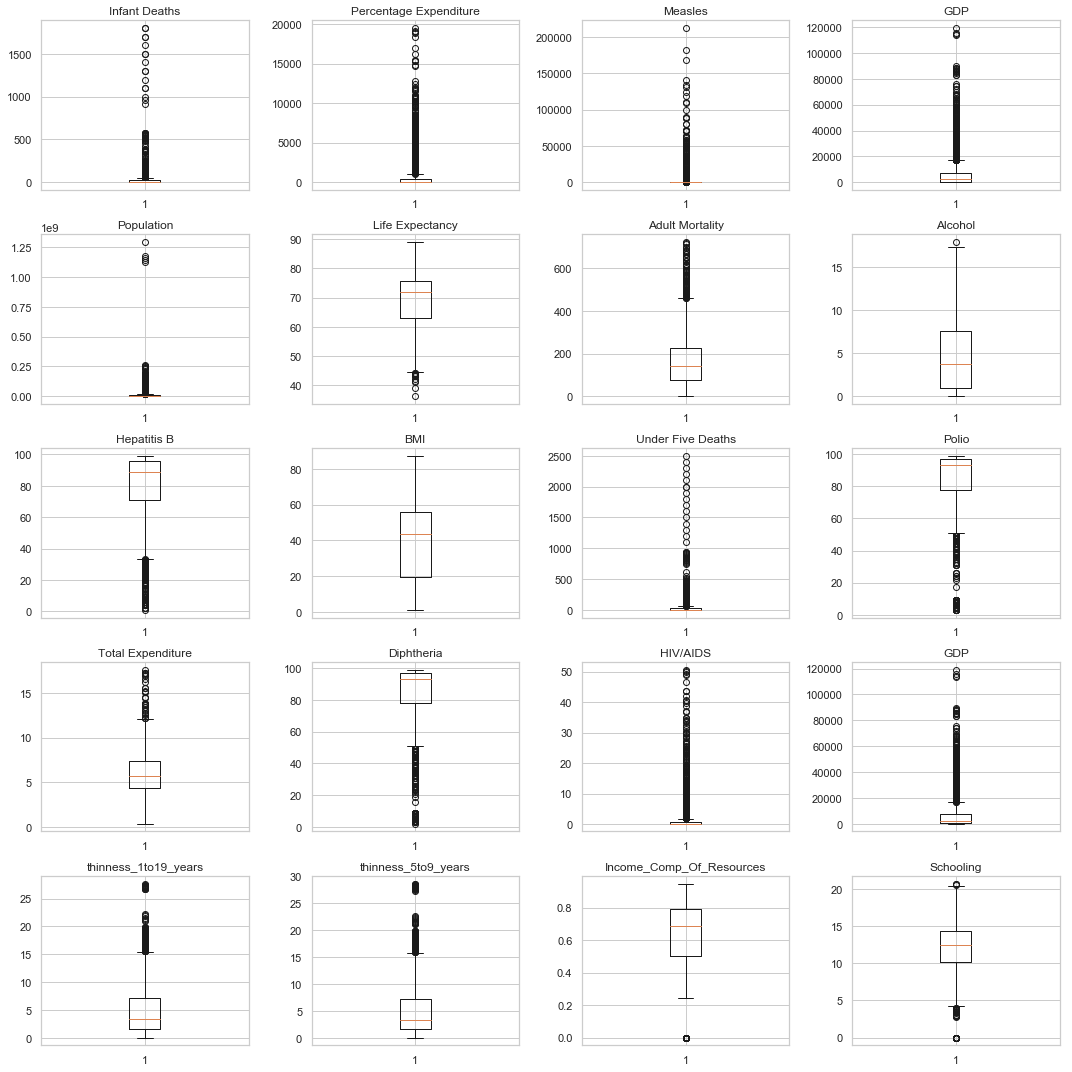

In [0]:
#let's check for outliers
plt.figure(figsize=(15,15))

plt.subplot(5,4,1)
plt.boxplot(life_df['Infant_Deaths'])
plt.title('Infant Deaths')

plt.subplot(5,4,2)
plt.boxplot(life_df['Percentage_Expenditure'])
plt.title('Percentage Expenditure')

plt.subplot(5,4,3)
plt.boxplot(life_df['Measles'])
plt.title('Measles')

plt.subplot(5,4,4)
plt.boxplot(life_df['GDP'])
plt.title('GDP')

plt.subplot(5,4,5)
plt.boxplot(life_df['Population'])
plt.title('Population')

plt.subplot(5,4,6)
plt.boxplot(life_df['Life_Expectancy'])
plt.title('Life Expectancy')

plt.subplot(5,4,7)
plt.boxplot(life_df['Adult_Mortality'])
plt.title('Adult Mortality')

plt.subplot(5,4,8)
plt.boxplot(life_df['Alcohol'])
plt.title('Alcohol')

plt.subplot(5,4,9)
plt.boxplot(life_df['Hepatitis_B'])
plt.title('Hepatitis B')

plt.subplot(5,4,10)
plt.boxplot(life_df['BMI'])
plt.title('BMI')

plt.subplot(5,4,11)
plt.boxplot(life_df['Under_Five_Deaths'])
plt.title('Under Five Deaths')

plt.subplot(5,4,12)
plt.boxplot(life_df['Polio'])
plt.title('Polio')

plt.subplot(5,4,13)
plt.boxplot(life_df['Tot_Exp'])
plt.title('Total Expenditure')

plt.subplot(5,4,14)
plt.boxplot(life_df['Diphtheria'])
plt.title('Diphtheria')

plt.subplot(5,4,15)
plt.boxplot(life_df['HIV/AIDS'])
plt.title('HIV/AIDS')

plt.subplot(5,4,16)
plt.boxplot(life_df['GDP'])
plt.title('GDP')

plt.subplot(5,4,17)
plt.boxplot(life_df['thinness_1to19_years'])
plt.title('thinness_1to19_years')

plt.subplot(5,4,18)
plt.boxplot(life_df['thinness_5to9_years'])
plt.title('thinness_5to9_years')

plt.subplot(5,4,19)
plt.boxplot(life_df['Income_Comp_Of_Resources'])
plt.title('Income_Comp_Of_Resources')

plt.subplot(5,4,20)
plt.boxplot(life_df['Schooling'])
plt.title('Schooling')

plt.tight_layout()
plt.show()

We can see that every variable (except BMI) has outliers, some more than others. Considering how extreme some of these outliers are, we should clean them up to avoid issues in our analysis. The winsorization method seems appropriate here.

Text(0.5,1,'Winsorized Life Expectancy')

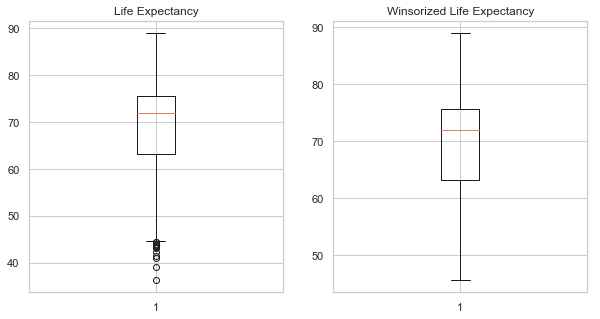

In [0]:
#winsorize the variables to clean the outliers
#lets first take a look at our target variable

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
life_expectancy = life_df['Life_Expectancy']
plt.boxplot(life_expectancy)
plt.title('Life Expectancy')

plt.subplot(1,2,2)
winsorized_life_expectancy = winsorize(life_df['Life_Expectancy'], (0.01, 0))
plt.boxplot(winsorized_life_expectancy)
plt.title('Winsorized Life Expectancy')

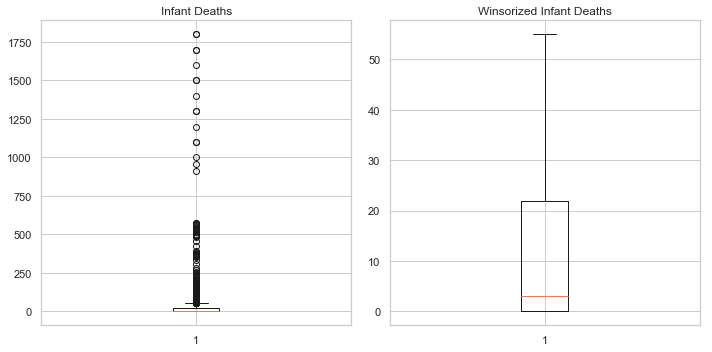

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
infant_deaths = life_df['Infant_Deaths']
plt.boxplot(infant_deaths)
plt.title('Infant Deaths')

plt.subplot(1,2,2)
winsorized_infant_deaths = winsorize(life_df['Infant_Deaths'], (0, 0.11))
plt.boxplot(winsorized_infant_deaths)
plt.title('Winsorized Infant Deaths')

plt.tight_layout()
plt.show()

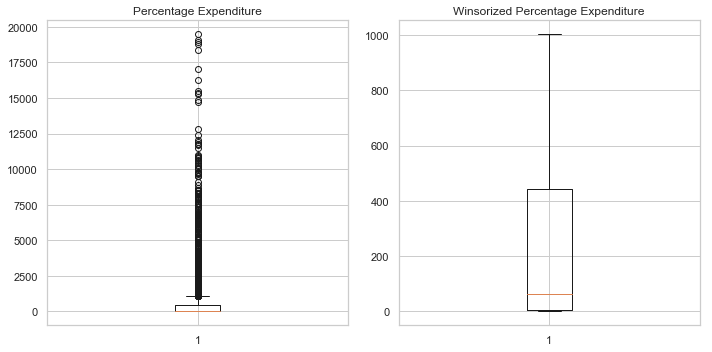

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
percentage_expenditure = life_df['Percentage_Expenditure']
plt.boxplot(percentage_expenditure)
plt.title('Percentage Expenditure')

plt.subplot(1,2,2)
winsorized_percentage_expenditure = winsorize(life_df['Percentage_Expenditure'], (0, 0.14))
plt.boxplot(winsorized_percentage_expenditure)
plt.title('Winsorized Percentage Expenditure')

plt.tight_layout()
plt.show()

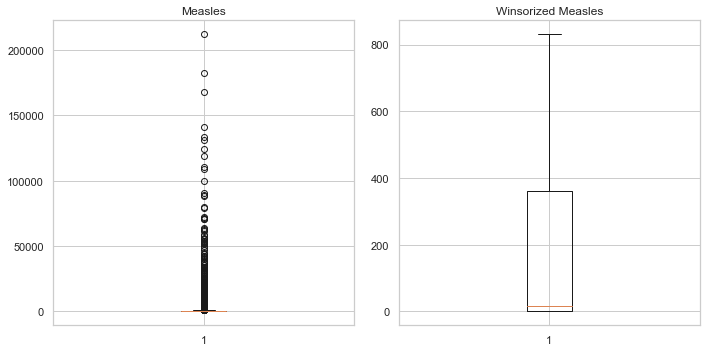

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
measles = life_df['Measles']
plt.boxplot(measles)
plt.title('Measles')

plt.subplot(1,2,2)
winsorized_measles = winsorize(life_df['Measles'], (0, 0.19))
plt.boxplot(winsorized_measles)
plt.title('Winsorized Measles')

plt.tight_layout()
plt.show()

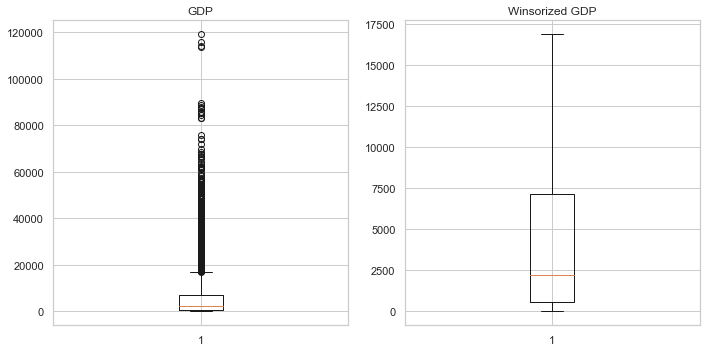

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
gdp = life_df['GDP']
plt.boxplot(gdp)
plt.title('GDP')

plt.subplot(1,2,2)
winsorized_gdp = winsorize(life_df['GDP'], (0, 0.12))
plt.boxplot(winsorized_gdp)
plt.title('Winsorized GDP')

plt.tight_layout()
plt.show()

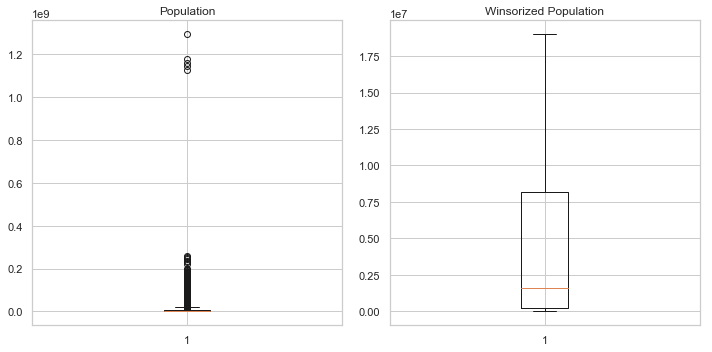

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
population = life_df['Population']
plt.boxplot(population)
plt.title('Population')

plt.subplot(1,2,2)
winsorized_population = winsorize(life_df['Population'], (0, 0.13))
plt.boxplot(winsorized_population)
plt.title('Winsorized Population')

plt.tight_layout()
plt.show()

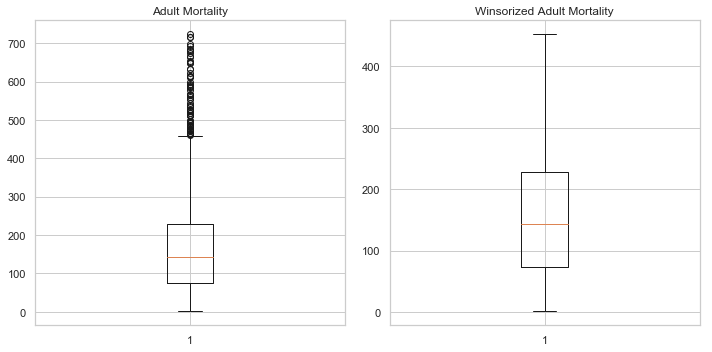

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
adult_mortality = life_df['Adult_Mortality']
plt.boxplot(adult_mortality)
plt.title('Adult Mortality')

plt.subplot(1,2,2)
winsorized_adult_mortality = winsorize(life_df['Adult_Mortality'], (0, 0.03))
plt.boxplot(winsorized_adult_mortality)
plt.title('Winsorized Adult Mortality')

plt.tight_layout()
plt.show()

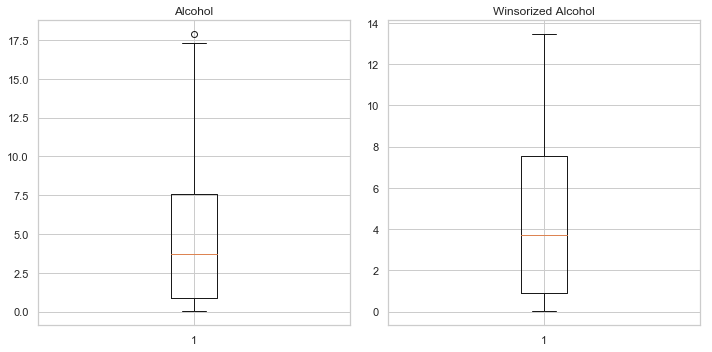

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
alcohol = life_df['Alcohol']
plt.boxplot(alcohol)
plt.title('Alcohol')

plt.subplot(1,2,2)
winsorized_alcohol = winsorize(life_df['Alcohol'], (0, 0.01))
plt.boxplot(winsorized_alcohol)
plt.title('Winsorized Alcohol')

plt.tight_layout()
plt.show()

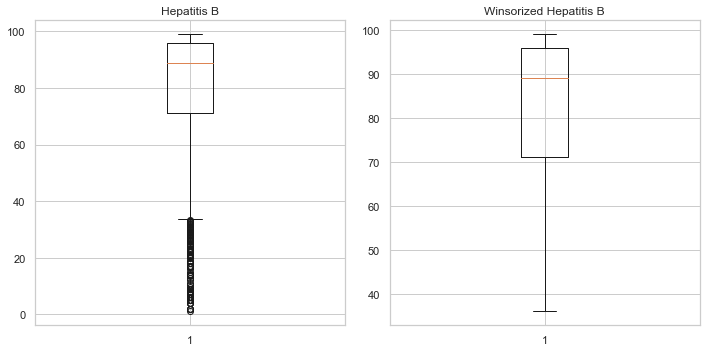

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
hepatitis_b = life_df['Hepatitis_B']
plt.boxplot(hepatitis_b)
plt.title('Hepatitis B')

plt.subplot(1,2,2)
winsorized_hepatitis_b = winsorize(life_df['Hepatitis_B'], (0.09, 0))
plt.boxplot(winsorized_hepatitis_b)
plt.title('Winsorized Hepatitis B')

plt.tight_layout()
plt.show()

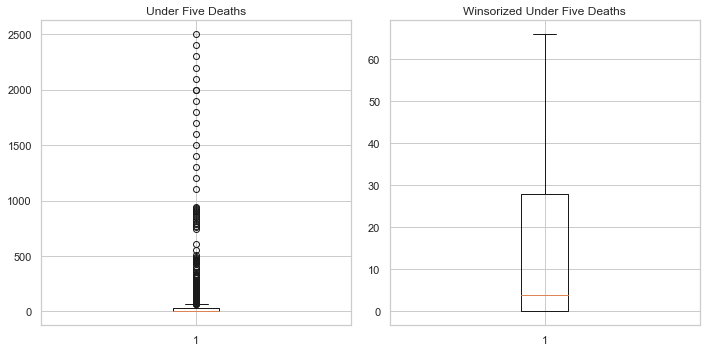

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
under_five_deaths = life_df['Under_Five_Deaths']
plt.boxplot(under_five_deaths)
plt.title('Under Five Deaths')

plt.subplot(1,2,2)
winsorized_under_five_deaths = winsorize(life_df['Under_Five_Deaths'], (0, 0.14))
plt.boxplot(winsorized_under_five_deaths)
plt.title('Winsorized Under Five Deaths')

plt.tight_layout()
plt.show()

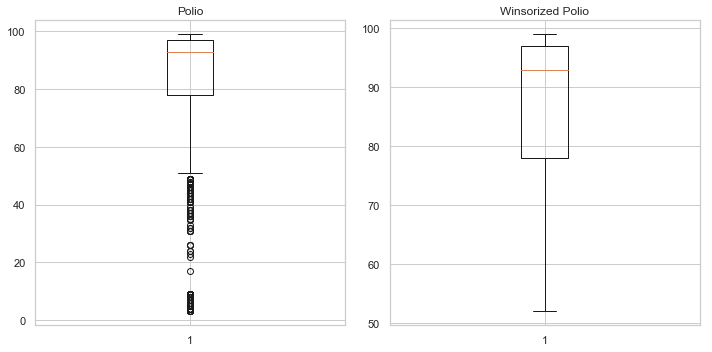

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
polio = life_df['Polio']
plt.boxplot(polio)
plt.title('Polio')

plt.subplot(1,2,2)
winsorized_polio = winsorize(life_df['Polio'], (0.1,0))
plt.boxplot(winsorized_polio)
plt.title('Winsorized Polio')

plt.tight_layout()
plt.show()

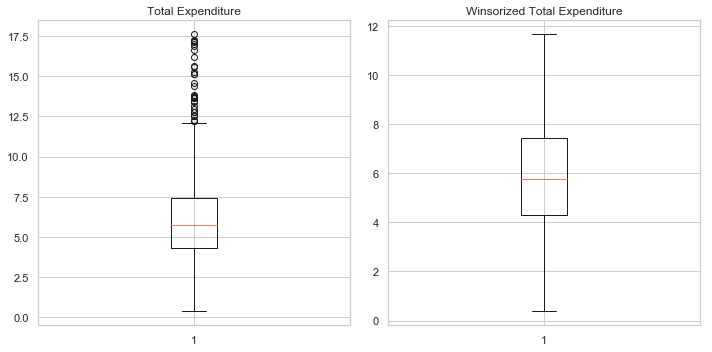

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
total_expenditure = life_df['Tot_Exp']
plt.boxplot(total_expenditure)
plt.title('Total Expenditure')

plt.subplot(1,2,2)
winsorized_total_expenditure = winsorize(life_df['Tot_Exp'], (0, 0.02))
plt.boxplot(winsorized_total_expenditure)
plt.title('Winsorized Total Expenditure')

plt.tight_layout()
plt.show()

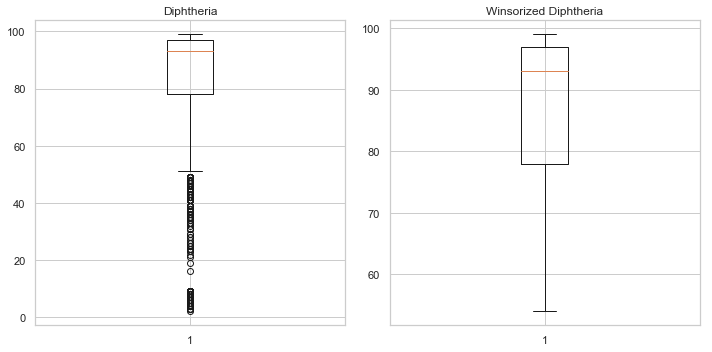

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
diphtheria = life_df['Diphtheria']
plt.boxplot(diphtheria)
plt.title('Diphtheria')

plt.subplot(1,2,2)
winsorized_diphtheria = winsorize(life_df['Diphtheria'], (0.11,0))
plt.boxplot(winsorized_diphtheria)
plt.title('Winsorized Diphtheria')

plt.tight_layout()
plt.show()

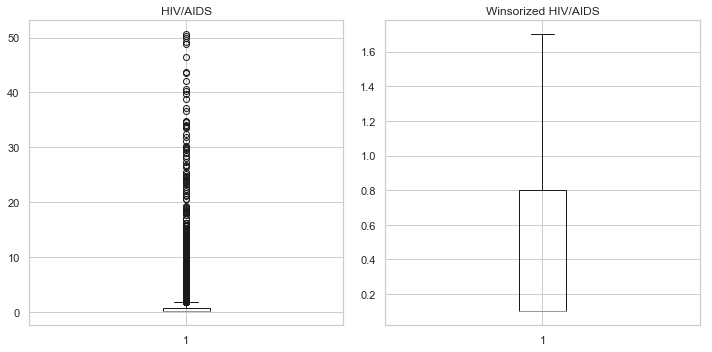

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
hivaids = life_df['HIV/AIDS']
plt.boxplot(hivaids)
plt.title('HIV/AIDS')

plt.subplot(1,2,2)
winsorized_hivaids = winsorize(life_df['HIV/AIDS'], (0,0.19))
plt.boxplot(winsorized_hivaids)
plt.title('Winsorized HIV/AIDS')

plt.tight_layout()
plt.show()

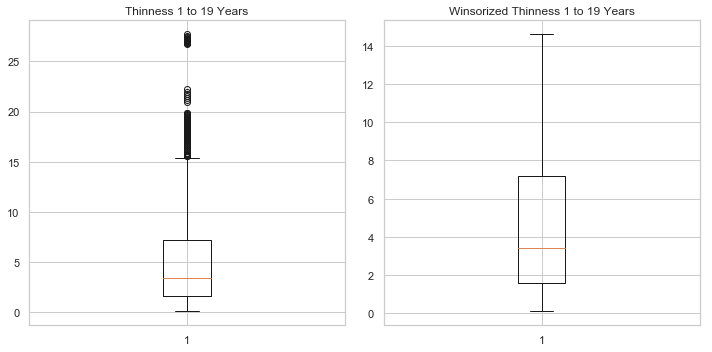

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
thinness_1to19 = life_df['thinness_1to19_years']
plt.boxplot(thinness_1to19)
plt.title('Thinness 1 to 19 Years')

plt.subplot(1,2,2)
winsorized_thinness_1to19 = winsorize(life_df['thinness_1to19_years'], (0,0.04))
plt.boxplot(winsorized_thinness_1to19)
plt.title('Winsorized Thinness 1 to 19 Years')

plt.tight_layout()
plt.show()

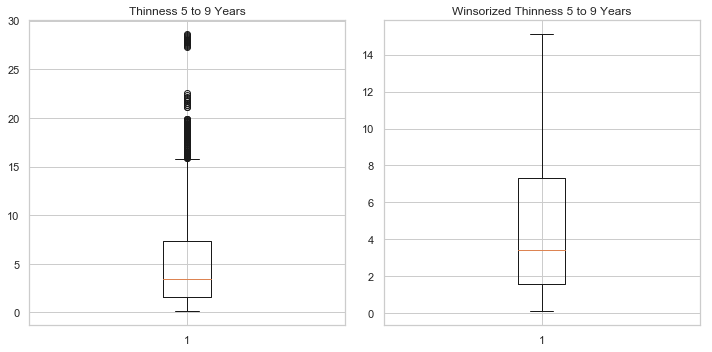

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
thinness_5to9 = life_df['thinness_5to9_years']
plt.boxplot(thinness_5to9)
plt.title('Thinness 5 to 9 Years')

plt.subplot(1,2,2)
winsorized_thinness_5to9 = winsorize(life_df['thinness_5to9_years'], (0,0.04))
plt.boxplot(winsorized_thinness_5to9)
plt.title('Winsorized Thinness 5 to 9 Years')

plt.tight_layout()
plt.show()

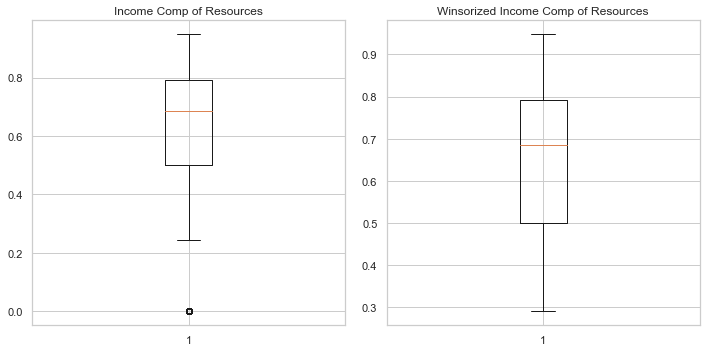

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
income_comp_of_resources = life_df['Income_Comp_Of_Resources']
plt.boxplot(income_comp_of_resources)
plt.title('Income Comp of Resources')

plt.subplot(1,2,2)
winsorized_income_comp_of_resources = winsorize(life_df['Income_Comp_Of_Resources'], (0.05,0))
plt.boxplot(winsorized_income_comp_of_resources)
plt.title('Winsorized Income Comp of Resources')

plt.tight_layout()
plt.show()

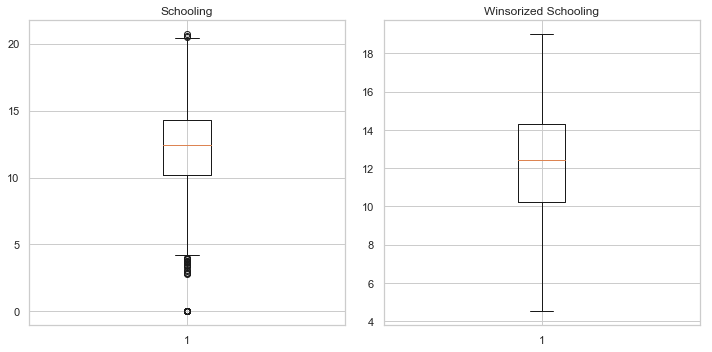

In [0]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
schooling = life_df['Schooling']
plt.boxplot(schooling)
plt.title('Schooling')

plt.subplot(1,2,2)
winsorized_schooling = winsorize(life_df['Schooling'], (0.02,0.01))
plt.boxplot(winsorized_schooling)
plt.title('Winsorized Schooling')

plt.tight_layout()
plt.show()

In [0]:
pd.set_option('display.max_columns', 500)

In [0]:
#add the winsorized variables to our data frame

life_df['winsorized_life_expectancy'] = winsorized_life_expectancy
life_df['winsorized_infant_deaths'] = winsorized_infant_deaths
life_df['winsorized_percentage_expenditure'] = winsorized_percentage_expenditure
life_df['winsorized_total_expenditure'] = winsorized_total_expenditure
life_df['winsorized_measles'] = winsorized_measles
life_df['winsorized_gdp'] = winsorized_gdp
life_df['winsorized_population'] = winsorized_population
life_df['winsorized_adult_mortality'] = winsorized_adult_mortality
life_df['winsorized_alcohol'] = winsorized_alcohol
life_df['winsorized_hepatitis_b'] = winsorized_hepatitis_b
life_df['winsorized_under_five_deaths'] = winsorized_under_five_deaths
life_df['winsorized_polio'] = winsorized_polio
life_df['winsorized_total_expenditure'] = winsorized_total_expenditure
life_df['winsorized_diphtheria'] = winsorized_diphtheria
life_df['winsorized_hivaids'] = winsorized_hivaids
life_df['winsorized_thinness_1to19'] = winsorized_thinness_1to19
life_df['winsorized_thinness_5to9'] = winsorized_thinness_5to9
life_df['winsorized_income_comp_of_resources'] = winsorized_income_comp_of_resources
life_df['winsorized_schooling'] = winsorized_schooling



In [0]:
#using tukey's method again to verify our winsorization 

winsor_list = ['winsorized_life_expectancy', 'winsorized_infant_deaths', 'winsorized_percentage_expenditure', 'winsorized_total_expenditure', 'winsorized_measles', 
              'winsorized_gdp', 'winsorized_population', 'winsorized_adult_mortality', 'winsorized_alcohol', 'winsorized_hepatitis_b', 
              'winsorized_under_five_deaths', 'winsorized_polio', 'winsorized_total_expenditure', 'winsorized_diphtheria', 'winsorized_hivaids',
              'winsorized_thinness_1to19', 'winsorized_thinness_5to9', 'winsorized_income_comp_of_resources', 'winsorized_schooling']

for var in winsor_list:
    q75, q25 = np.percentile(life_df[var], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(var, len((np.where((life_df[var] > max_val) | (life_df[var] < min_val))[0]))))

Number of outliers in winsorized_life_expectancy: 0
Number of outliers in winsorized_infant_deaths: 0
Number of outliers in winsorized_percentage_expenditure: 0
Number of outliers in winsorized_total_expenditure: 0
Number of outliers in winsorized_measles: 0
Number of outliers in winsorized_gdp: 0
Number of outliers in winsorized_population: 0
Number of outliers in winsorized_adult_mortality: 0
Number of outliers in winsorized_alcohol: 0
Number of outliers in winsorized_hepatitis_b: 0
Number of outliers in winsorized_under_five_deaths: 0
Number of outliers in winsorized_polio: 0
Number of outliers in winsorized_total_expenditure: 0
Number of outliers in winsorized_diphtheria: 0
Number of outliers in winsorized_hivaids: 0
Number of outliers in winsorized_thinness_1to19: 0
Number of outliers in winsorized_thinness_5to9: 0
Number of outliers in winsorized_income_comp_of_resources: 0
Number of outliers in winsorized_schooling: 0


# Data Exploration

In [0]:
#univariate statistics
life_df.describe(include='all')

,Country,Year,Status,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling,winsorized_life_expectancy,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_total_expenditure,winsorized_measles,winsorized_gdp,winsorized_population,winsorized_adult_mortality,winsorized_alcohol,winsorized_hepatitis_b,winsorized_under_five_deaths,winsorized_polio,winsorized_diphtheria,winsorized_hivaids,winsorized_thinness_1to19,winsorized_thinness_5to9,winsorized_income_comp_of_resources,winsorized_schooling
count,2938,2938.000000,2938,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Lithuania,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,82.474643,5.940955,82.246086,1.742103,7432.027910,1.229209e+07,4.882301,4.920439,0.634458,12.076804,69.231892,13.635126,271.234472,5.905245,220.691287,4921.644837,5.257499e+06,161.839517,4.535512,80.471006,17.417971,85.470169,85.643927,0.508237,4.719677,4.753987,0.647398,12.120724
std,NaN,4.613841,NaN,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,23.420689,2.445751,23.705664,5.077785,13410.150286,5.471908e+07,4.433359,4.532488,0.209574,3.342316,9.464636,19.108928,363.172291,2.331962,329.192321,5794.931696,6.748727e+06,115.303588,3.960835,20.380218,24.075262,15.332736,14.807990,0.640847,3.901667,3.977301,0.176384,3.175113
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,45.600000,0.000000,0.000000,0.370000,0.000000,1.681350,3.400000e+01,1.000000,0.010000,36.000000,0.000000,52.000000,54.000000,0.100000,0.100000,0.100000,0.290000,4.500000
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,78.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000,63.100000,0.000000,4.685343,4.312500,0.000000,553.618620,2.536025e+05,74.000000,0.902500,71.000000,0.000000,78.000000,78.000000,0.100000,1.600000,1.600000,0.500000,10.200000
50%,NaN,2008.000000,NaN,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000,72.000000,3.000000,64.912906,5.760000,17.000000,2192.681084,1.576319e+06,144.000000,3.697500,89.000000,4.000000,93.000000,93.000000,0.100000,3.400000,3.400000,0.684000,12.400000
75%,NaN,2012.000000,NaN,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000,75.600000,22.000000,441.534144,7.440000,360.250000,7183.381694,8.215738e+06,228.000000,7.550000,96.000000,28.000000,97.000000,97.000000,0.800000,7.200000,7.300000,0.791107

In [0]:
#correlation table
life_df.corr()

,Year,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling,winsorized_life_expectancy,winsorized_infant_deaths,winsorized_percentage_expenditure,winsorized_total_expenditure,winsorized_measles,winsorized_gdp,winsorized_population,winsorized_adult_mortality,winsorized_alcohol,winsorized_hepatitis_b,winsorized_under_five_deaths,winsorized_polio,winsorized_diphtheria,winsorized_hivaids,winsorized_thinness_1to19,winsorized_thinness_5to9,winsorized_income_comp_of_resources,winsorized_schooling
Year,1.000000,0.168309,-0.079264,-0.037415,-0.064487,0.031400,0.145777,-0.082493,0.100417,-0.042937,0.095580,0.079345,0.135174,-0.139741,0.089699,0.019915,-0.038570,-0.040661,0.223818,0.185780,0.167629,-0.047331,0.033419,0.078063,-0.118772,0.089857,0.022316,-0.066495,-0.065637,0.170650,-0.052700,0.118496,0.149467,-0.087581,-0.039254,-0.038701,0.193774,0.181186
Life_Expectancy,0.168309,1.000000,-0.695730,-0.196197,0.400068,0.382069,0.247419,-0.157298,0.556433,-0.222151,0.459865,0.210843,0.474084,-0.555929,0.435854,-0.007126,-0.476809,-0.472485,0.690071,0.703409,0.999613,-0.564702,0.488325,0.215346,-0.335674,0.486264,0.004491,-0.690042,0.402043,0.282363,-0.604594,0.569382,0.579194,-0.795083,-0.523637,-0.519255,0.783010,0.724501
Adult_Mortality,-0.079264,-0.695730,1.000000,0.078762,-0.194070,-0.242587,-0.162578,0.031226,-0.383224,0.094134,-0.272553,-0.116293,-0.273311,0.523245,-0.283332,-0.025440,0.307734,0.314769,-0.440536,-0.430481,-0.694340,0.364846,-0.309964,-0.114599,0.202113,-0.312101,0.000181,0.987040,-0.195897,-0.185026,0.393293,-0.340555,-0.344432,0.601738,0.349000,0.355552,-0.505678,-0.440448
Infant_Deaths,-0.037415,-0.196197,0.078762,1.000000,-0.114836,-0.085612,-0.200825,0.501128,-0.226540,0.996629,-0.169385,-0.126114,-0.173944,0.025231,-0.107450,0.538589,0.462953,0.467439,-0.132327,-0.173790,-0.197147,0.468122,-0.145698,-0.130635,0.343455,-0.139778,0.212091,0.086439,-0.114955,-0.210613,0.446195,-0.229994,-0.233078,0.098759,0.305819,0.309587,-0.159548,-0.184221
Alcohol,-0.064487,0.400068,-0.194070,-0.114836,1.000000,0.337902,0.092366,-0.050497,0.319618,-0.112036,0.222830,0.289631,0.218683,-0.048190,0.342275,-0.029223,-0.420123,-0.408260,0.442169,0.507064,0.401644,-0.329724,0.385778,0.298197,-0.197157,0.426421,-0.000550,-0.203706,0.999040,0.103229,-0.340645,0.272984,0.279442,-0.202814,-0.441270,-0.430521,0.502771,0.524177
Percentage_Expenditure,0.031400,0.382069,-0.242587,-0.085612,0.337902,1.000000,-0.033524,-0.056596,0.228084,-0.087852,0.147584,0.169770,0.144017,-0.097857,0.871453,-0.016310,-0.252133,-0.253622,0.359488,0.369717,0.383292,-0.222573,0.656106,0.182690,-0.089865,0.599613,0.000886,-0.253271,0.339948,-0.048289,-0.227600,0.178334,0.179987,-0.203100,-0.271912,-0.274401,0.405115,0.380232
Hepatitis_B,0.145777,0.247419,-0.162578,-0.200825,0.092366,-0.033524,1.000000,-0.129531,0.172639,-0.208634,0.446056,0.088999,0.532925,-0.117155,0.031839,-0.080645,-0.141744,-0.150593,0.193478,0.201451,0.248506,-0.222473,0.069540,0.095401,-0.198569,0.097468,-0.008266,-0.164205,0.091685,0.977166,-0.228721,0.499391,0.556437,-0.239795,-0.127672,-0.135833,0.216933,0.207603
Measles,-0.082493,-0.157298,0.031226,0.501128,-0.050497,-0.056596,-0.129531,1.000000,-0.175347,0.507809,-0.135067,-0.102920,-0.140774,0.030899,-0.067382,0.229798,0.222427,0.217983,-0.087650,-0.082928,-0.158103,0.347858,-0.105070,-0.104943,0.384333,-0.083277,0.080305,0.032493,-0.050249,-0.135236,0.336445,-0.166174,-0.166397,0.107629,0.183919,0.180460,-0.087704,-0.086728
BMI,0.100417,0.556433,-0.383224,-0.226540,0.319618,0.228084,0.172639,-0.175347,1.000000,-0.236850,0.282080,0.233848,0.280483,-0.243181,0.271717,-0.060964,-0.533952,-0.540459,0.461457,0.488210,0.557811,-0.448371,0.329547,0.228903,-0.319263,0.325749,-0.024275,-0.395439,0.320142,0.196378,-0.469603,0.341747,0.343102,-0.482970,-0.5

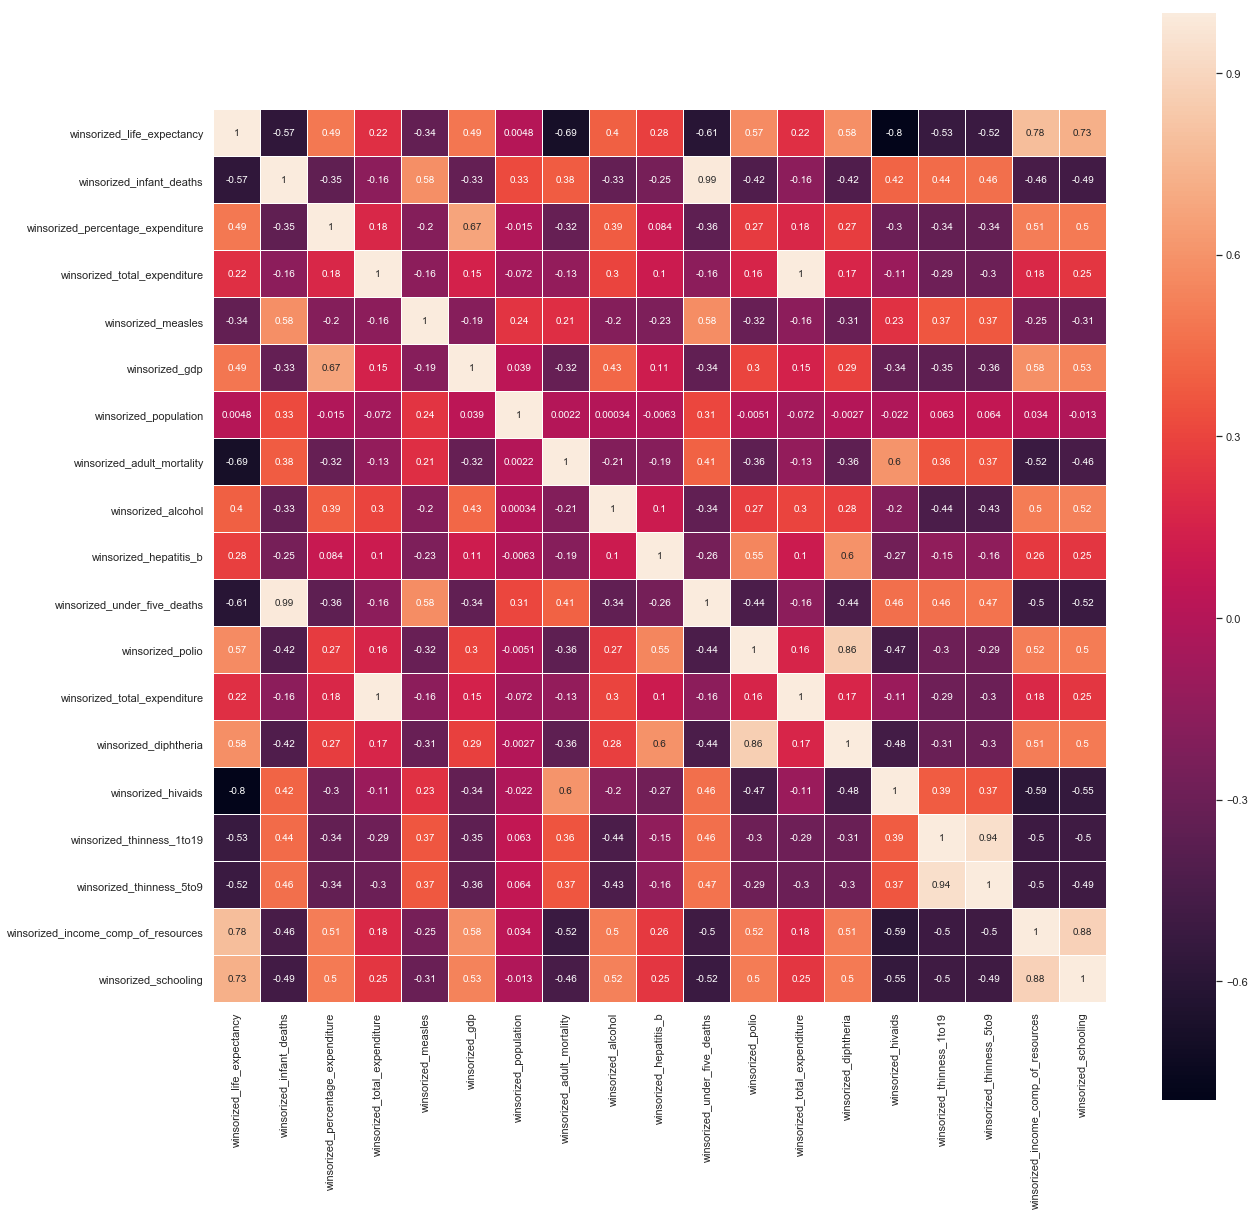

In [0]:
#heat map to visualize corrleations between winsorized variables

cormat_life = life_df[['winsorized_life_expectancy', 'winsorized_infant_deaths', 'winsorized_percentage_expenditure', 'winsorized_total_expenditure', 'winsorized_measles', 
              'winsorized_gdp', 'winsorized_population', 'winsorized_adult_mortality', 'winsorized_alcohol', 'winsorized_hepatitis_b', 
              'winsorized_under_five_deaths', 'winsorized_polio', 'winsorized_total_expenditure', 'winsorized_diphtheria', 'winsorized_hivaids',
              'winsorized_thinness_1to19', 'winsorized_thinness_5to9', 'winsorized_income_comp_of_resources', 'winsorized_schooling']].corr()

plt.figure(figsize=(20,20))
sns.heatmap(cormat_life, square=True, annot=True, linewidths=.5)
plt.show()

Using our heat map as a guide, we can see that winsorized schooling, winsorized income comp of resources, winsorized adult mortality and winsorized HIV/AIDS have a strong correlation with winsorized life expectancy. We can also see that winsorized infant deaths, winsorized under 5 deaths, winsorized polio, winsorized diphtheria, winsorized thinness 5 to 9 and winsorized thinness 1 to 19 have a slight correlation with our target variable - winsorized life expectancy.

We can also see correlations between our correlated variables. Let's plot these out to get a good visual.

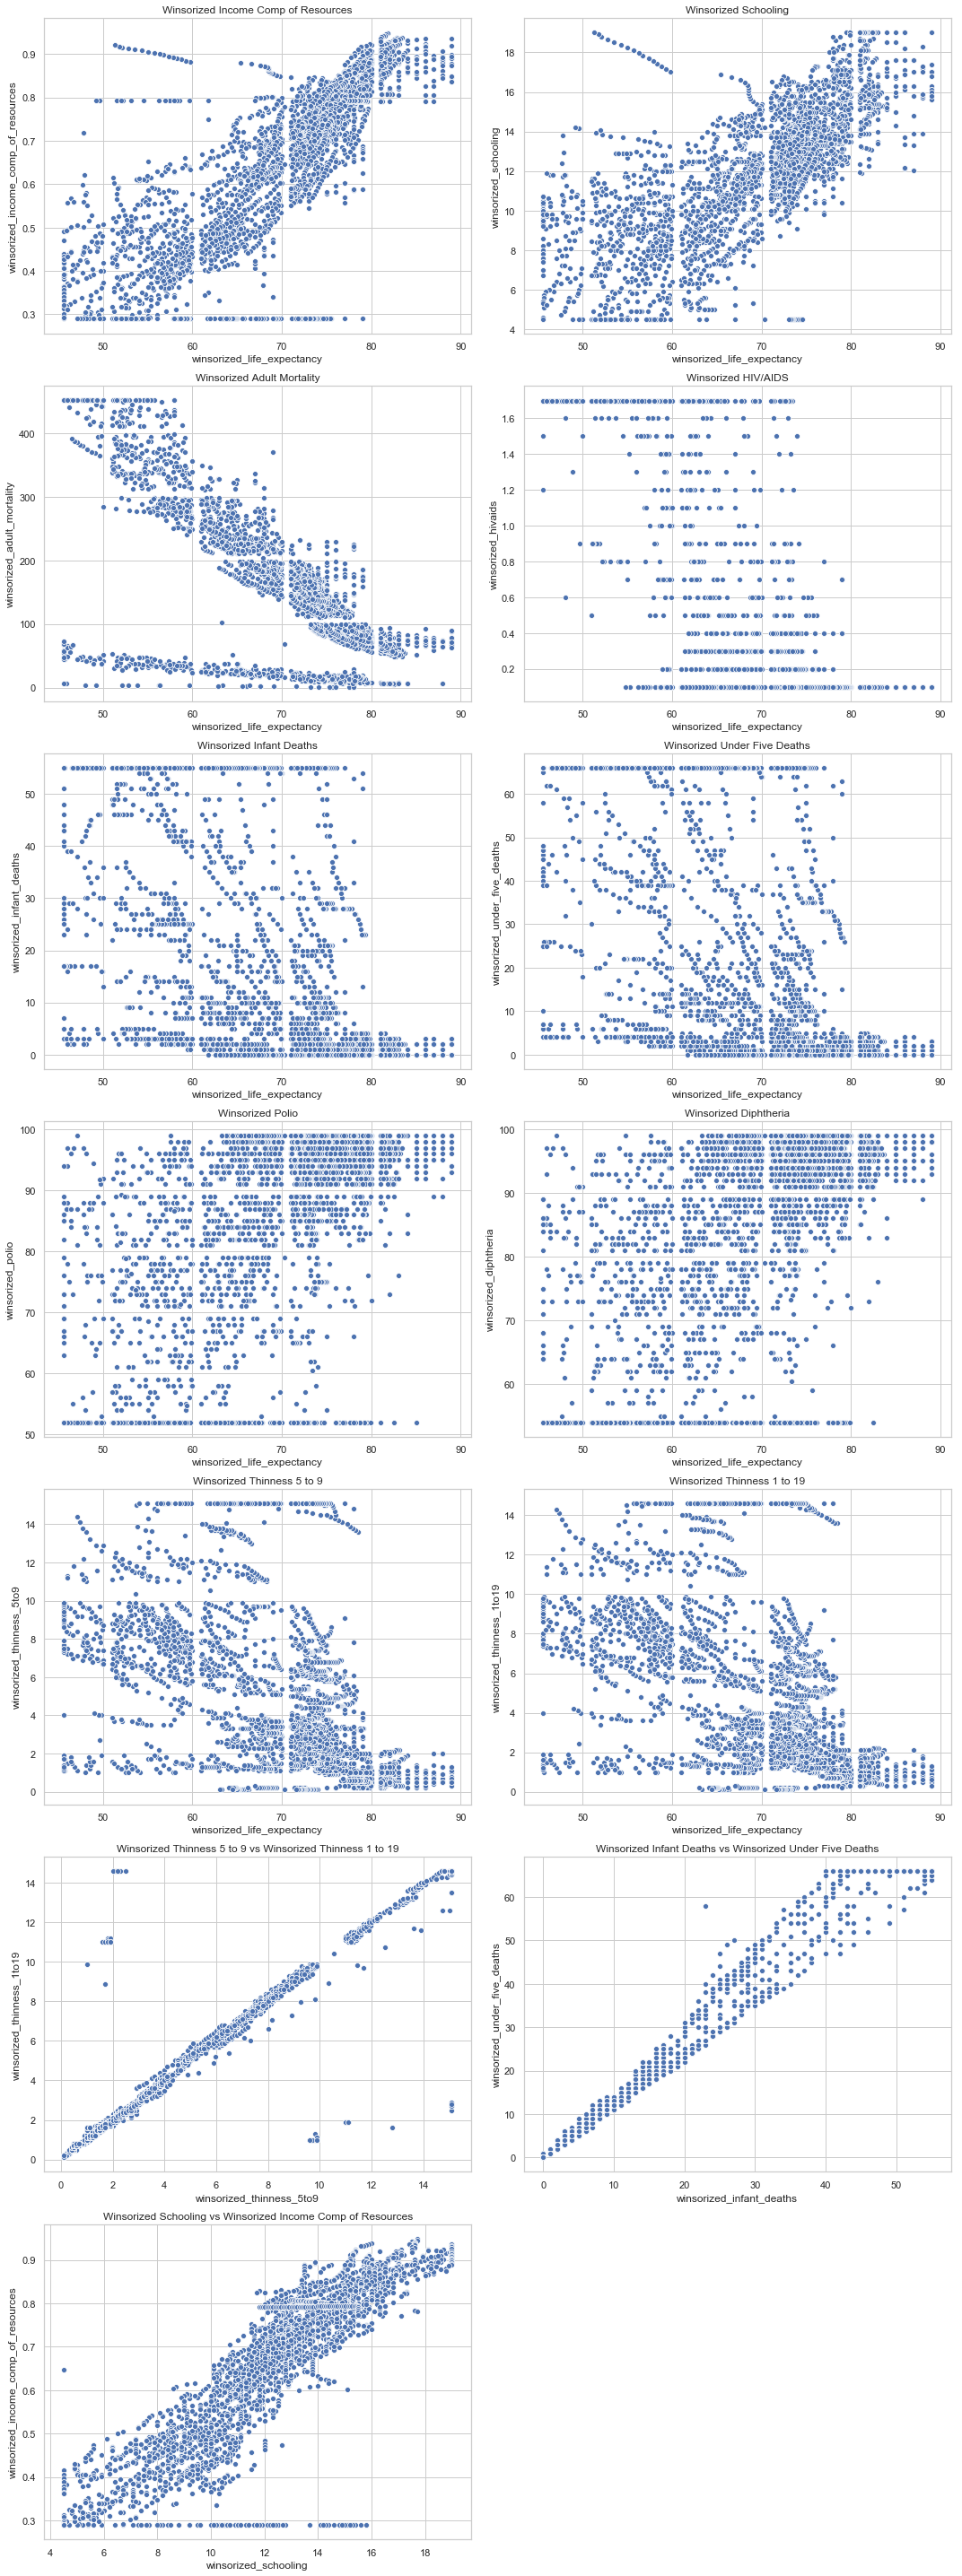

In [0]:
#plot the strongest correlations to life expectancy as seen from the table

plt.figure(figsize=(15,40))
plt.subplot(7,2,1)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_income_comp_of_resources', data=life_df)
plt.title('Winsorized Income Comp of Resources')

plt.subplot(7,2,2)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_schooling', data=life_df)
plt.title('Winsorized Schooling')

plt.subplot(7,2,3)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_adult_mortality', data=life_df)
plt.title('Winsorized Adult Mortality')

plt.subplot(7,2,4)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_hivaids', data=life_df)
plt.title('Winsorized HIV/AIDS')

plt.subplot(7,2,5)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_infant_deaths', data=life_df)
plt.title('Winsorized Infant Deaths')

plt.subplot(7,2,6)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_under_five_deaths', data=life_df)
plt.title('Winsorized Under Five Deaths')

plt.subplot(7,2,7)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_polio', data=life_df)
plt.title('Winsorized Polio')

plt.subplot(7,2,8)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_diphtheria', data=life_df)
plt.title('Winsorized Diphtheria')

plt.subplot(7,2,9)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_thinness_5to9', data=life_df)
plt.title('Winsorized Thinness 5 to 9')

plt.subplot(7,2,10)
sns.scatterplot(x='winsorized_life_expectancy', y='winsorized_thinness_1to19', data=life_df)
plt.title('Winsorized Thinness 1 to 19')

plt.subplot(7,2,11)
sns.scatterplot(x='winsorized_thinness_5to9', y='winsorized_thinness_1to19', data=life_df)
plt.title('Winsorized Thinness 5 to 9 vs Winsorized Thinness 1 to 19')

plt.subplot(7,2,12)
sns.scatterplot(x='winsorized_infant_deaths', y='winsorized_under_five_deaths', data=life_df)
plt.title('Winsorized Infant Deaths vs Winsorized Under Five Deaths')

plt.subplot(7,2,13)
sns.scatterplot(x='winsorized_schooling', y='winsorized_income_comp_of_resources', data=life_df)
plt.title('Winsorized Schooling vs Winsorized Income Comp of Resources')

plt.tight_layout()
plt.show()

We can see some interesting correlations from the scatterplots above. We will come back to these in our feature engineering step.

Lets take a look at our categorical variable "Status", to see if whether developed vs developing countries have a strong correlation with our target variable.

In [0]:
#look at the categorical variable
life_df.describe(include = ['O'])

,Country,Status
count,2938,2938
unique,193,2
top,Lithuania,Developing
freq,16,2426


Text(0.5,1,'Country Status vs Winsorized Life Expectancy')

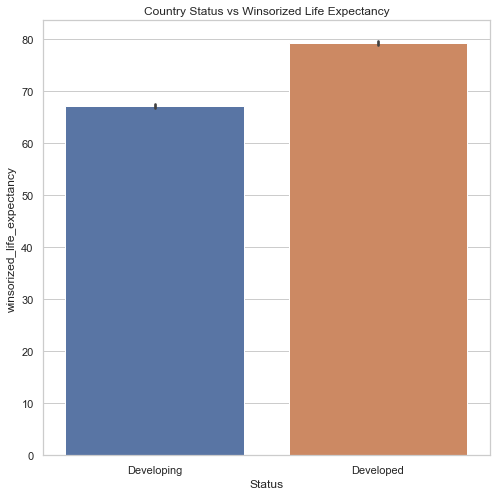

In [0]:
#plot the data
plt.figure(figsize=(8,8))

sns.barplot(x='Status', y='winsorized_life_expectancy', data=life_df)
plt.title('Country Status vs Winsorized Life Expectancy')

In [0]:
#analyze the status variable to see if there is statistical significance

stats.ttest_ind(life_df.loc[life_df['Status']=='Developed','winsorized_life_expectancy'],life_df.loc[life_df['Status']=='Developing','winsorized_life_expectancy'])

Ttest_indResult(statistic=29.95462938660176, pvalue=2.9323745212760544e-172)

As we can see, there is statistical significance between the relation of developed and developing countries in regards to life expectancy. We can add status to our list of variables that is strongly related to our target variable, winsorized life expectancy. 

Text(0.5,1,'Year vs Winsorized Life Expectancy')

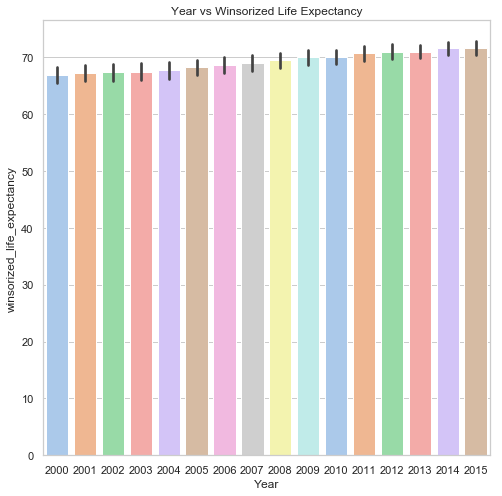

In [0]:
#does life expectancy change year over year?
plt.figure(figsize=(8,8))

sns.barplot(x='Year', y='winsorized_life_expectancy', data=life_df, palette='pastel')
plt.title('Year vs Winsorized Life Expectancy')

Using this visual and the correlation matrix, the year variable doesn't have much correlation with life expectancy so we will ignore this variable. 

# Feature Engineering

From our analysis above, we have found five variables that are strongly corrleated with our target variable (winsorized life expectancy). 

 - Status
 - Winsorized Income Composition of Resources
 - Winsorized Schooling
 - Infant Deaths
 - Under Five Deaths
 - Polio 
 - Diphtheria
 - Thinness 5 to 9
 - Thinness 1 to 19
 - Winsorized Adult Mortality
 - Winsorized HIV/AIDS
 
Many models assume that features are correlated with the outcome but uncorrelated with each other. With that in mind, we can see that Winsorized Income Composition of Resources and Winsorized Schooling are strongly correlated with a value of 0.88. Let's compare Winsorized Income Composition of Resources and Winsorized Schooling to Winsorized Life Expectancy to see which variable should be kept as a feature.

- Winsorized Life Expectancy vs Winsorized Income Composition of Resources = 0.78
- Winsorized Life Expectancy vs Winsorized Schooling = 0.73

We can also see that Infant Deaths and Under Five deaths are strongly correlated with one another. Since these are somewhat redundant, let's eliminate the weaker correlated variable from our feature list.

- Winsorized Life Expectancy vs Winsorized Infant Deaths = -0.57
- Winsorized Life Expectancy vs Winsorized Under Five Deaths = -0.61


Winsorized thinness 1 to 19 and winsorized thinness 5 to 9 are also strongly correlated with one another. Let's compare these two and eliminate the weaker correlated variable.

- Winsorized Life Expectancy vs Winsorized Thinness 5 to 9 = -0.52
- Winsorized Life Expectancy vs Winsorized Thinness 1 to 19 = -0.53



Given the analysis, we can drop Winsorized Schooling, Winsorized Infant Deaths and Winsorized Thinness 5 to 9 from the feature list, making our final list of features below:

 - Status
 - Winsorized Under Five Deaths
 - Winsorized Thinness 1 to 19
 - Winsorized Polio
 - Winsorized Diphtheria
 - Winsorized Income Composition of Resources
 - Winsorized Adult Mortality
 - Winsorized HIV/AIDS

Since most models assume the target variable to be normally distributed, let's check on our target variable, winsorized life expectancy. 

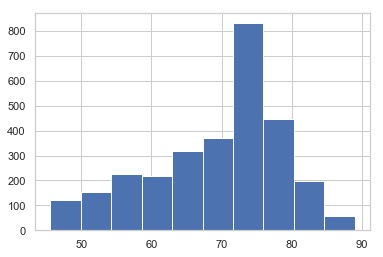

In [0]:
plt.hist(life_df['winsorized_life_expectancy'])
plt.show()

In [0]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(life_df["winsorized_life_expectancy"])
norm_stats = normaltest(life_df["winsorized_life_expectancy"])
print('Jarque Bera: {}'.format(jb_stats))
print('Normality: {}'.format(norm_stats))

Jarque Bera: (195.20802367202938, 0.0)
Normality: NormaltestResult(statistic=174.69148673143553, pvalue=1.1647310104682202e-38)


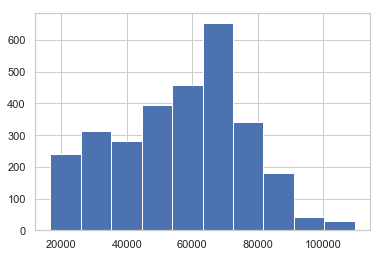

In [0]:
#since many machine learning models assume normal distribution, lets adjust our target variable with a boxcox transformation

from scipy.stats import boxcox

winsorized_life_expectancy_boxcox,_ = boxcox(life_df["winsorized_life_expectancy"])

plt.hist(winsorized_life_expectancy_boxcox)
plt.show()

In [0]:
#test the boxcox transformation
jb_stats = jarque_bera(winsorized_life_expectancy_boxcox)
norm_stats = normaltest(winsorized_life_expectancy_boxcox)
print('Jarque Bera: {}'.format(jb_stats))
print('Normality: {}'.format(norm_stats))

Jarque Bera: (44.15754731082998, 2.5781632384536124e-10)
Normality: NormaltestResult(statistic=82.76459036404538, pvalue=1.0663445507613961e-18)


A boxcox transformation seems to help make our target variable more normal.

In [0]:
#create final dataframe with our features

feature_life_df = life_df[['winsorized_life_expectancy', 'Status', 'winsorized_income_comp_of_resources', 'winsorized_adult_mortality',
                         'winsorized_hivaids', 'winsorized_under_five_deaths', 'winsorized_polio', 'winsorized_diphtheria',
                          'winsorized_thinness_1to19']]


In [0]:
#convert the categorical variable to numeric

feature_life_df = pd.concat([feature_life_df,pd.get_dummies(feature_life_df['Status'],drop_first=True)],axis=1)
final_feature_life_df = feature_life_df.drop('Status', axis=1)
final_feature_life_df.head()

,winsorized_life_expectancy,winsorized_income_comp_of_resources,winsorized_adult_mortality,winsorized_hivaids,winsorized_under_five_deaths,winsorized_polio,winsorized_diphtheria,winsorized_thinness_1to19,Developing
0,65.0,0.479,263.0,0.1,66,52.0,65.0,14.605882,1
1,59.9,0.476,271.0,0.1,66,58.0,62.0,14.605882,1
2,59.9,0.470,268.0,0.1,66,62.0,64.0,14.605882,1
3,59.5,0.463,272.0,0.1,66,67.0,67.0,14.605882,1
4,59.2,0.454,275.0,0.1,66,68.0,68.0,14.605882,1


In [0]:
#standardize the feature data, and add to the final feature dataframe

from sklearn.preprocessing import scale

final_feature_life_df["scaled_winsorized_income_comp_of_resources"] = scale(final_feature_life_df["winsorized_income_comp_of_resources"])
final_feature_life_df["scaled_winsorized_adult_mortality"] = scale(final_feature_life_df["winsorized_adult_mortality"])
final_feature_life_df["scaled_winsorized_hivaids"] = scale(final_feature_life_df["winsorized_hivaids"])
final_feature_life_df["scaled_winsorized_polio"] = scale(final_feature_life_df["winsorized_polio"])
final_feature_life_df["scaled_winsorized_diphtheria"] = scale(final_feature_life_df["winsorized_diphtheria"])
final_feature_life_df["scaled_winsorized_thinness_1to19"] = scale(final_feature_life_df["winsorized_thinness_1to19"])
final_feature_life_df["scaled_boxcox_life_expectancy"] = scale(winsorized_life_expectancy_boxcox)

final_feature_life_df.head()

,winsorized_life_expectancy,winsorized_income_comp_of_resources,winsorized_adult_mortality,winsorized_hivaids,winsorized_under_five_deaths,winsorized_polio,winsorized_diphtheria,winsorized_thinness_1to19,Developing,scaled_winsorized_income_comp_of_resources,scaled_winsorized_adult_mortality,scaled_winsorized_hivaids,scaled_winsorized_polio,scaled_winsorized_diphtheria,scaled_winsorized_thinness_1to19,scaled_boxcox_life_expectancy
0,65.0,0.479,263.0,0.1,66,52.0,65.0,14.605882,1,-0.954882,0.877490,-0.637136,-2.183294,-1.394345,2.534273,-0.574616
1,59.9,0.476,271.0,0.1,66,58.0,62.0,14.605882,1,-0.971893,0.946884,-0.637136,-1.791908,-1.596972,2.534273,-1.046889
2,59.9,0.470,268.0,0.1,66,62.0,64.0,14.605882,1,-1.005915,0.920861,-0.637136,-1.530983,-1.461887,2.534273,-1.046889
3,59.5,0.463,272.0,0.1,66,67.0,67.0,14.605882,1,-1.045608,0.955558,-0.637136,-1.204828,-1.259259,2.534273,-1.081007
4,59.2,0.454,275.0,0.1,66,68.0,68.0,14.605882,1,-1.096642,0.981580,-0.637136,-1.139597,-1.191717,2.534273,-1.106324


# Summary

As we can see from the data, the most correlated variables, in no particular order, to our target variable are:

 - Status:
 Developed countries have an increased life expectancy in relation to developing countries. This was confirmed by statistical significance testing.
 - Winsorized Under Five Deaths:
 Deaths under the age of five obviously have a negative impact on life expectancy. It was one of the weaker correlated variables within the dataset but I included it nontheless.
 - Winsorized Thinness 1 to 19:
 Thinness ages 1 to 19 has a negative correlation with life expectancy in our data. 
 - Winsorized Polio:
 Polio immunizations has a positive correlation with life expectancy, as expected. 
 - Winsorized Diphtheria:
 As with polio, diphtheria immunizations have a positive effect on life expectancy.
 - Winsorized Income Composition of Resources:
 The strongest positively correlated variable of the bunch. Income composition of Resources has a major positive correlation with our target variable.
 - Winsorized Adult Mortality:
 A strong negative correlation with life expectancy, as one would expect.
 - Winsorized HIV/AIDS:
 The strongest negatively correlated variable, deaths per 1000 people of HIV/AIDS has a major impact on life expectancy.
 

